No overlap in training and testing dates.
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.1991 - mae: 0.3139 - val_loss: 0.0975 - val_mae: 0.3005
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0284 - mae: 0.1205 - val_loss: 0.0436 - val_mae: 0.1929
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0220 - mae: 0.1049 - val_loss: 0.0319 - val_mae: 0.1616
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0195 - mae: 0.0989 - val_loss: 0.0159 - val_mae: 0.1091
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0186 - mae: 0.0949 - val_loss: 0.0087 - val_mae: 0.0775
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0169 - mae: 0.0930 - val_loss: 0.0080 - val_mae: 0.0738
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0158 - mae: 0.0896 - val_loss: 0.0139 - val_mae: 0.1017
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0157 - mae: 0.0882 - val_loss: 0.0047 - val_mae: 0.0546
Epoch 9/50
89/89 ━━━━━

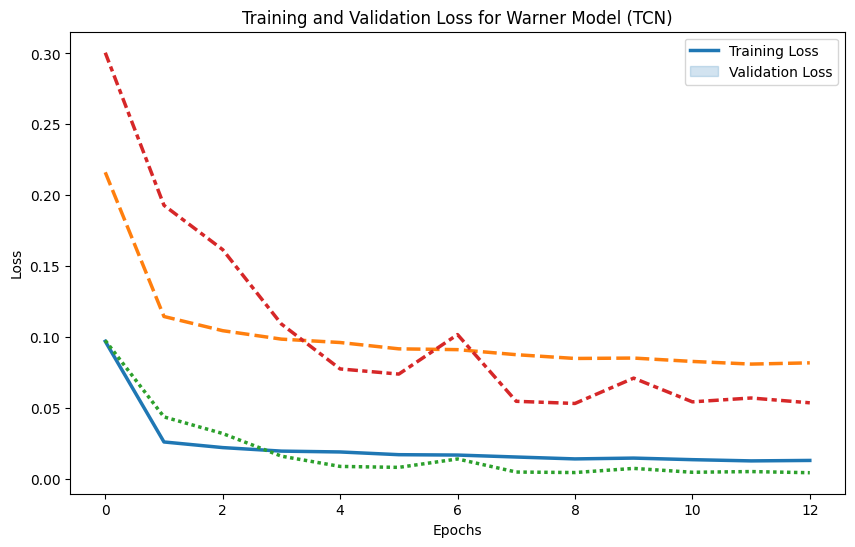

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# loading datasets
training_file_path = 'datasets/training_warner.csv'
testing_file_path = 'datasets/testing_warner.csv'

training_data = pd.read_csv(training_file_path)
testing_data = pd.read_csv(testing_file_path)

# column names t lowercase
training_data.columns = training_data.columns.str.lower()
testing_data.columns = testing_data.columns.str.lower()

# date column do datetime format
training_data['date'] = pd.to_datetime(training_data['date'], errors='coerce')
testing_data['date'] = pd.to_datetime(testing_data['date'], errors='coerce')

# checking for overlap
train_dates = set(training_data['date'])
test_dates = set(testing_data['date'])

overlap = train_dates.intersection(test_dates)
if overlap:
    print("Warning: There is an overlap in training and testing dates.")
else:
    print("No overlap in training and testing dates.")

# sing close values as target variable
train_close_values = training_data['close'].values.reshape(-1, 1)

# normalizing the data to stabilize training the model
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_close_values)

# function to create sequences of data for time series input
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 90  # using the past 90 days to predict the next day
X_train, y_train = create_sequences(train_scaled, time_steps)

# TCN model, defining a function to create TCN block
def TCNBlock(input_tensor, filters, kernel_size, dilation_rate, dropout_rate=0.2):
    #first convolutional layer with causal padding and dilation
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(input_tensor)
    # activations for stable training
    x = BatchNormalization()(x)
    # relu activation
    x = ReLU()(x)
    # dropout for regularization
    x = Dropout(dropout_rate)(x)
    # saving the input for residual connection
    skip = x
    # second convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    return Add()([skip, x])

# input layer for time series data
input_layer = Input(shape=(time_steps, 1))
# stacking multiple TCN blocks with increasing dilation rates
x = TCNBlock(input_layer, filters=32, kernel_size=2, dilation_rate=1)
x = TCNBlock(x, filters=32, kernel_size=2, dilation_rate=2)
x = TCNBlock(x, filters=32, kernel_size=2, dilation_rate=4)

#reduciing temporal dimension
x = GlobalAveragePooling1D()(x)
# connected layer with relu
x = Dense(32, activation='relu')(x)
# dropout for regularization
x = Dropout(0.3)(x)
#output to predict next stock price
output_layer = Dense(1)(x)
# defining the model
model = Model(inputs=input_layer, outputs=output_layer)

#training and compiling model
optimizer = Adam(learning_rate=0.001) # compiling with Adam optimizer and mse loss
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# early stopping and callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)
model_checkpoint = ModelCheckpoint(filepath='best_warner_tcn_model.keras', monitor='val_loss', save_best_only=True)

# training the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split=0.2, #using 20% of data for validation
                    callbacks=[early_stopping, model_checkpoint])

# plotting training history
plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history, palette='tab10', linewidth=2.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Warner Model (TCN)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


The chart shows that training and validation loss steady decreases, which means that model is learning well. There is a small gap that indicates good generalization and small overfitting.

This model uses TCN (Temporal Convulutional Network). I used this model because I found out that is well suited for time series forecasting because it can handle longer dependencies. It also efficiently learns patterns over long time periods.

To prepare the dataset I converted it to appropriate formats and checked for overlapping. I normalized prices using MinMaxScaler to stabilize training. I created function that makes 90 day sequences so the model predicts day based on past 90 days. 

Input Layer in the model handles time series sequences with my function of 90 days. Three TCN blocks with increasing dilation rates capture short term and long term dependencies. To reduce temporal dimension (single vector) to simplify the output I used Global Pooling. The dense layers predict the next price without reducing overfitting. To mimimize mse I used Adam optimiser. I also use EarlyStopping to prevent overfitting and to save time when validation doesn't improve. Also ModelCheckpoint to save best performing model.



36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


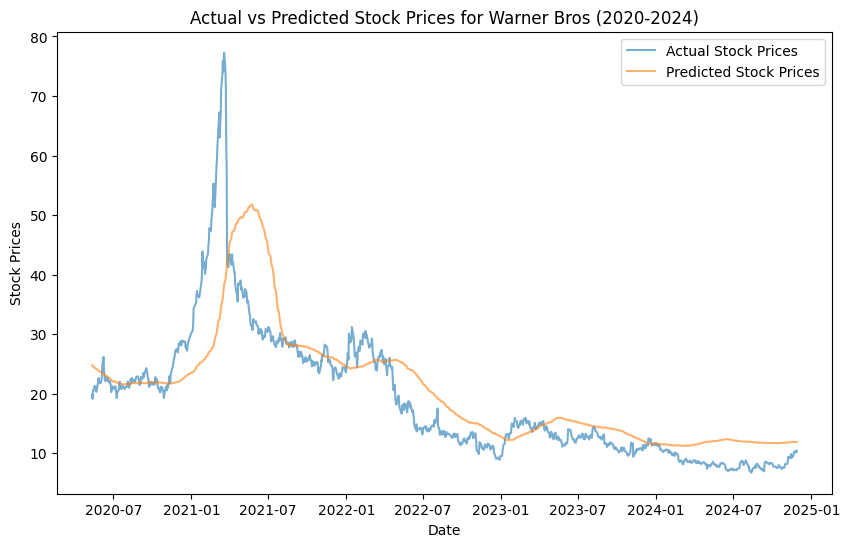

Warner Bros Model - Mean Squared Error: 51.54295026997683
Warner Bros Model - Mean Absolute Error: 4.439271495396346
Warner Bros Model - Root Mean Squared Error: 7.179341910647301
Warner Bros Model - R2 Score: 0.5929680524362575


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# preparing data for predictions for Warner Bros
warner_test_close_values = testing_data['close'].values.reshape(-1, 1)

# scaling the future data using the scaler fitted on training data
warner_test_scaled = scaler.transform(warner_test_close_values)

# creating sequences for predictions
def create_future_sequences(data, time_steps):
    """
    Generates sequences for time-series predictions.
    """
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
    return np.array(X)

# matching time steps
time_steps = 90  
X_test_warner = create_future_sequences(warner_test_scaled, time_steps)

# predicting stock prices for Warner Bros
y_pred_warner = model.predict(X_test_warner)

# inverse transform and actual values
predicted_warner = scaler.inverse_transform(y_pred_warner).flatten()
actual_warner = warner_test_close_values[time_steps:].flatten()

# plotting actual vs predicted stock prices for Warner Bros
plt.figure(figsize=(10, 6))
sns.lineplot(
    x=testing_data['date'].iloc[time_steps:], 
    y=actual_warner, 
    label='Actual Stock Prices', alpha=0.6
)
sns.lineplot(
    x=testing_data['date'].iloc[time_steps:], 
    y=predicted_warner, 
    label='Predicted Stock Prices', alpha=0.6
)
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.title('Actual vs Predicted Stock Prices for Warner Bros (2020-2024)')
plt.legend()
plt.show()

# metrics calculation for Warner Bros
mse_warner = mean_squared_error(actual_warner, predicted_warner)
mae_warner = mean_absolute_error(actual_warner, predicted_warner)
rmse_warner = np.sqrt(mse_warner)
r2_warner = r2_score(actual_warner, predicted_warner)

print(f"Warner Bros Model - Mean Squared Error: {mse_warner}")
print(f"Warner Bros Model - Mean Absolute Error: {mae_warner}")
print(f"Warner Bros Model - Root Mean Squared Error: {rmse_warner}")
print(f"Warner Bros Model - R2 Score: {r2_warner}")

To predict the prices I had to prepare the testing thata to match it with training data. Then the model predicts the prices and they are converted into original scale to compare. 

# Conclusion
The chart shows that the model follows overall trend of the stock. However the  R² score could be improved to explain all variations. The MAE and RMSE show us the good accuracy and that the model has good balance between precision and generalization. To sum up the model performs well when it comes to trend prediction but it struggles with short term volatility.